# Imports

In [1]:
# install required libraries
!pip install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jortg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jortg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Loading the data

In [3]:
data_folder_name = 'A4data_2526_pan2020'
DATA_FOLDER = Path(data_folder_name)
DEV_SET = None
TEST_SET = None
TRAIN_SET = None

if not DATA_FOLDER.exists():
    print(f"ERROR: Data folder not found, make sure the '/{data_folder_name}' folder is located in the same folder as this notebook!")
else:
    try:
        DEV_SET = pd.read_csv(DATA_FOLDER / 'pan2526_dev_data.csv')
        TEST_SET = pd.read_csv(DATA_FOLDER / 'pan2526_test_data.csv')
        TRAIN_SET = pd.read_csv(DATA_FOLDER / 'pan2526_train_data.csv')
        print('Data loaded successfully')
    except FileNotFoundError:
        print(f"ERROR: Data not found in '/{DATA_FOLDER}'")
    

Data loaded successfully


Let's have a look at the DEV data:

In [4]:
DEV_SET

,Unnamed: 0,text,author
0,3329,The last part of the pictorial will now begin!...,560480
1,1225,"""It is a huge body of water."" It was slow yet ...",560480
2,3334,"As she reached for the door, the sound of a ca...",512464
3,3573,Despite the scowl that seemed to be forever pl...,2750536
4,1429,The traditional institutions did not take the ...,1112924
...,...,...,...
263,1432,"""Still thinking about it, Kuwabara-jiisan,"" Hi...",1112924
264,1838,"""Well, if it isn""t tha"" police kitteh."" Seras ...",1220273
265,3328,"""I think I have seen that clothes before..."" L...",560480
266,470,"""I almost didn""t turn away from you, even when...",1220273


# Extract features

In [5]:
def get_char_features(data_frame):
    # some char count fetaures
    data_frame['snippet_length'] = data_frame['text'].str.len()
    data_frame['comma'] = data_frame['text'].str.count(r',') / data_frame['snippet_length']
    data_frame['period'] = data_frame['text'].str.count(r'\.') / data_frame['snippet_length']
    data_frame['exclam'] = data_frame['text'].str.count(r'\!') / data_frame['snippet_length']
    data_frame['question'] = data_frame['text'].str.count(r'\?') / data_frame['snippet_length']
    data_frame['upper_case'] = data_frame['text'].str.count(r'[A-Z]') / data_frame['snippet_length']
    data_frame['lower_case'] = data_frame['text'].str.count(r'[a-z]') / data_frame['snippet_length']
    
    # some aggregated char count features
    data_frame['vowel_frequency'] = data_frame['text'].str.count(r'[aeiou]') / data_frame['snippet_length']
    data_frame['avg_word_len'] = data_frame['text'].apply(lambda x: sum(len(w) for w in x.split()) / len(x.split()) if x.split() else 0)
    
    # make sure any features you want to be used during training are also in this list:
    feature_names = [
        'snippet_length', 
        'comma', 
        'period', 
        'exclam', 
        'question', 
        'upper_case',
        'lower_case',
        'vowel_frequency',
        'avg_word_len'
    ]
    
    return data_frame, feature_names

In [6]:
def get_word_features(data_frame):
    # count number of words
    data_frame['word_count'] = data_frame['text'].apply(
        lambda x: len(x.split())
    )
    # count the stopwords
    stop_words = set(stopwords.words('english'))
    data_frame['stopword_frequency'] = data_frame['text'].apply(
        lambda x: sum(1 for w in word_tokenize(x.lower()) if w in stop_words)
    ) / data_frame['word_count']
    
    # make sure any features you want to be used during training are also in this list:
    feature_names = [
        'word_count', 
        'stopword_frequency'
    ]
    
    return data_frame, feature_names

In [7]:
def extract_features(data_frame):
    """extracts relevant features"""
    # list of feature names we want to use for training
    feature_names = []
    
    # extract some character based features
    data_frame, ft_names = get_char_features(data_frame)
    feature_names += ft_names
    
    # extract stop word based features
    data_frame, ft_names = get_word_features(data_frame)
    feature_names += ft_names
    
    # return the data with the features and the list of feature names
    return data_frame, feature_names

In [8]:
class Model:
    """
    A wrapper class that is meant to wrap around an arbitrary machine learning model
    """
    def __init__(self, X_train, y_train, feature_names, *args, verbose=False, **kwargs):
        self.args=args
        self.kwargs=kwargs
        self.X_train=X_train[feature_names]
        self.y_train=y_train
        self.feature_names=feature_names
        self.verbose=verbose
    
    def fit(self):
        raise NotImplementedError

    def _test(self):
        raise NotImplementedError
    
    def _score_fn(self):
        raise NotImplementedError
        
    def predict(self, X_test, y_test):
        self.X_test=X_train[self.feature_names]
        self.y_test=y_test
        return self._test()
    
    def score(self, X_test, y_test):
        self.X_test=X_test[self.feature_names]
        self.y_test=y_test
        return self._score_fn()
    
    @classmethod
    def train_and_score(cls, X_train, y_train, X_test, y_test, feature_names, *args, verbose=False, **kwargs):
        model = cls(X_train, y_train, feature_names, *args, verbose=verbose, **kwargs)
        model.fit()
        return model.score(X_test, y_test)
    

class DecisionTree(Model):
    """
    Wrapper for the sklearn DecisionTree
    """
    def fit(self):
        self.model = DecisionTreeClassifier(*self.args, **self.kwargs)
        self.model.fit(self.X_train, self.y_train)
        
    def _test(self):
        # Make predictions
        return self.model.predict(self.X_test)
    
    def _score_fn(self):
        return self.model.score(self.X_test, self.y_test)
    
class RandomForest(Model):
    """
    Wrapper for the sklearn RandomForest
    """
    def fit(self):
        self.model = RandomForestClassifier(*self.args, **self.kwargs)
        self.model.fit(self.X_train, self.y_train)
        
    def _test(self):
        # Make predictions for the test set
        return self.model.predict(self.X_test)
    
    def _score_fn(self):
        # Get the accuracy on the test set
        return self.model.score(self.X_test, self.y_test)
        
    

In [9]:
def ablation_test(model_type:Model, data_frame, feature_names, *args, **kwargs):
    X = data_frame[feature_names]
    y = data_frame['author']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scores = {}
    # get the base score when using all features:
    scores['None'] = model_type.train_and_score(
        *args,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        feature_names=feature_names,
        **kwargs
    )
    
    # perform the acual ablation tests:
    for feature in feature_names:
        # copy the feature list and remove one:
        ablated_feature_names = feature_names.copy() 
        ablated_feature_names.remove(feature)  
        
        # for nicer printing in the plot func:
        prettified_feature_name = feature.replace("_", " ")  
        
        # train and test the model
        scores[prettified_feature_name] = model_type.train_and_score(
            *args,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            feature_names=ablated_feature_names,
            **kwargs
        )
        
    bars = plt.bar(scores.keys(), scores.values())
    bars[0].set_color('C1')
    #plt.xticks(rotation=90)   # rotate x-axis labels 90 degrees
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.xlabel('Ablated feature')
    plt.title(f'Ablation test ({model_type.__name__})')
    plt.show()
    

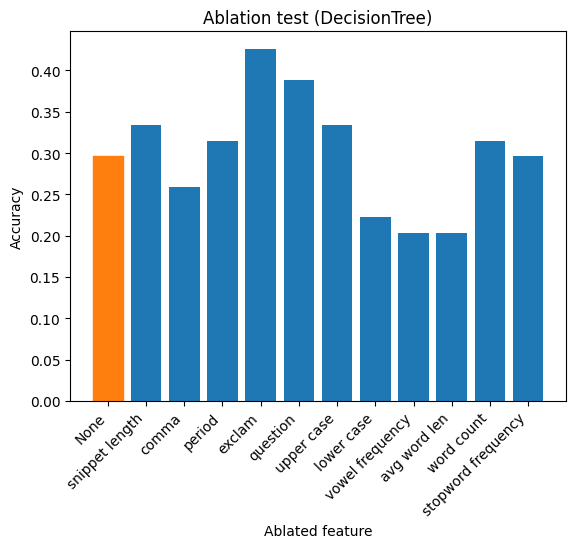

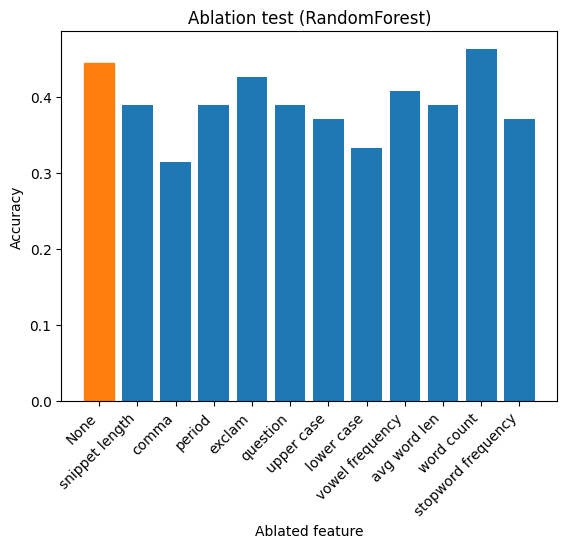

In [10]:
# create all the necessary features for the DEV set:
dev_with_features,dev_feature_names = extract_features(DEV_SET)

# dictionary with the selected model types and their optional arguments:
model_dict = {
    DecisionTree: {
        'args': [],
        'kwargs': {}
    },
    RandomForest:{
        'args': [],
        'kwargs': {'n_estimators': 100}
    }
}

# perform an ablation test on each type of model
for model_type, args_kwargs in model_dict.items():
    ablation_test(
        *args_kwargs["args"],
        model_type=model_type,
        data_frame=dev_with_features,
        feature_names=dev_feature_names,
        **args_kwargs["kwargs"]
    )

